In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

läsa in  Läs in förbehandlade tränings- och testdata

In [38]:
X_train = pd.read_csv("X_train.csv")
X_test = pd.read_csv("X_test.csv")
y_train = pd.read_csv("y_train.csv").values.ravel()
y_test = pd.read_csv("y_test.csv").values.ravel()


Standardisera funktionsdata

In [39]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

 Funktion för att utvärdera modeller och spara resultat

In [40]:
eval_results = []

def evaluate_model(model, X_test, y_test, name):
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    eval_results.append({
        "Modell": name,
        "Accuracy": acc,
        "Precision_1": report['1']['precision'],
        "Recall_1": report['1']['recall'],
        "F1_1": report['1']['f1-score']
    })
    print(f"\n📌 {name}:")
    print("Noggrannhet:", acc)
    print("Konfusionsmatris:\n", confusion_matrix(y_test, y_pred))
    print("Klassificeringsrapport:\n", classification_report(y_test, y_pred))

 Logistic Regression (utan vikt)

In [41]:
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train)
evaluate_model(log_model, X_test, y_test, "Logistic Regression")


📌 Logistic Regression:
Noggrannhet: 0.8693693693693694
Konfusionsmatris:
 [[374   8]
 [ 50  12]]
Klassificeringsrapport:
               precision    recall  f1-score   support

           0       0.88      0.98      0.93       382
           1       0.60      0.19      0.29        62

    accuracy                           0.87       444
   macro avg       0.74      0.59      0.61       444
weighted avg       0.84      0.87      0.84       444



C:\Users\riddl\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression (utan vikt)
Bra total noggrannhet (~86%)

Dålig på att hitta de som svarade (klass 1) → recall = 0.19

Logistic Regression med class_weight='balanced'

In [42]:
log_balanced = LogisticRegression(max_iter=1000, class_weight='balanced')
log_balanced.fit(X_train, y_train)
evaluate_model(log_balanced, X_test, y_test, "LogReg (balanced)")


📌 LogReg (balanced):
Noggrannhet: 0.704954954954955
Konfusionsmatris:
 [[265 117]
 [ 14  48]]
Klassificeringsrapport:
               precision    recall  f1-score   support

           0       0.95      0.69      0.80       382
           1       0.29      0.77      0.42        62

    accuracy                           0.70       444
   macro avg       0.62      0.73      0.61       444
weighted avg       0.86      0.70      0.75       444



Modellen offrar lite noggrannhet totalt sett för att bli mycket bättre på att hitta de som svarar (klass 1)

Det här är bra för affärsanvändning – företaget hittar fler verkligt intresserade kunder, även om du ibland gissar fel.

In [43]:
param_grid = {'n_neighbors': list(range(3, 21))}
gs_knn = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5)
gs_knn.fit(X_train, y_train)
evaluate_model(gs_knn.best_estimator_, X_test, y_test, f"KNN (k={gs_knn.best_params_['n_neighbors']})")


📌 KNN (k=17):
Noggrannhet: 0.8648648648648649
Konfusionsmatris:
 [[374   8]
 [ 52  10]]
Klassificeringsrapport:
               precision    recall  f1-score   support

           0       0.88      0.98      0.93       382
           1       0.56      0.16      0.25        62

    accuracy                           0.86       444
   macro avg       0.72      0.57      0.59       444
weighted avg       0.83      0.86      0.83       444



Automatisk sökning gav k=17 som bäst för accuracy

MEN:

F1-score för klass 1 = 0.25

Recall = 0.16 ❌ (väldigt låg)

Det betyder att även om modellen gissar rätt ofta totalt, så är den dålig på att hitta de som svarade på kampanjen.

GridSearchCV för KNN baserat på F1-score för klass 1

In [ ]:
from sklearn.metrics import make_scorer, f1_score

f1_scorer = make_scorer(f1_score, pos_label=1)
param_grid = {'n_neighbors': list(range(1, 21))}
grid_f1 = GridSearchCV(KNeighborsClassifier(), param_grid, scoring=f1_scorer, cv=5)
grid_f1.fit(X_train, y_train)

print("\nBästa k baserat på F1-score för klass 1:", grid_f1.best_params_)
print("Bästa F1-score (cross-val):", grid_f1.best_score_)

best_knn = grid_f1.best_estimator_
evaluate_model(best_knn, X_test, y_test, f"KNN (f1-optimal, k={grid_f1.best_params_['n_neighbors']})")


Bästa k baserat på F1-score för klass 1: {'n_neighbors': 1}
Bästa F1-score (cross-val): 0.2992537545543411

📌 KNN (f1-optimal, k=1):
Noggrannhet: 0.8536036036036037
Konfusionsmatris:
 [[357  25]
 [ 40  22]]
Klassificeringsrapport:
               precision    recall  f1-score   support

           0       0.90      0.93      0.92       382
           1       0.47      0.35      0.40        62

    accuracy                           0.85       444
   macro avg       0.68      0.64      0.66       444
weighted avg       0.84      0.85      0.84       444



KNN (k=1) fungerar också bra men är känslig för brus

In [ ]:
Random Forest

In [ ]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
evaluate_model(rf, X_test, y_test, "Random Forest")


📌 Random Forest:
Noggrannhet: 0.8873873873873874
Konfusionsmatris:
 [[376   6]
 [ 44  18]]
Klassificeringsrapport:
               precision    recall  f1-score   support

           0       0.90      0.98      0.94       382
           1       0.75      0.29      0.42        62

    accuracy                           0.89       444
   macro avg       0.82      0.64      0.68       444
weighted avg       0.87      0.89      0.87       444



In [ ]:
ganska bra F1-score för klass 1

In [ ]:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

log_pca = LogisticRegression(max_iter=1000)
log_pca.fit(X_train_pca, y_train)
evaluate_model(log_pca, X_test_pca, y_test, "LogReg med PCA")

knn_pca = KNeighborsClassifier(n_neighbors=5)
knn_pca.fit(X_train_pca, y_train)
evaluate_model(knn_pca, X_test_pca, y_test, "KNN med PCA")


📌 LogReg med PCA:
Noggrannhet: 0.8603603603603603
Konfusionsmatris:
 [[381   1]
 [ 61   1]]
Klassificeringsrapport:
               precision    recall  f1-score   support

           0       0.86      1.00      0.92       382
           1       0.50      0.02      0.03        62

    accuracy                           0.86       444
   macro avg       0.68      0.51      0.48       444
weighted avg       0.81      0.86      0.80       444


📌 KNN med PCA:
Noggrannhet: 0.8581081081081081
Konfusionsmatris:
 [[364  18]
 [ 45  17]]
Klassificeringsrapport:
               precision    recall  f1-score   support

           0       0.89      0.95      0.92       382
           1       0.49      0.27      0.35        62

    accuracy                           0.86       444
   macro avg       0.69      0.61      0.64       444
weighted avg       0.83      0.86      0.84       444



PCA-förminskning minskar förmågan att hitta klass 1

In [ ]:
results_df = pd.DataFrame(eval_results)
print("\n📊 Sammanfattande modelljämförelse:")
print(results_df.sort_values(by="F1_1", ascending=False))


📊 Sammanfattande modelljämförelse:
                Modell  Accuracy  Precision_1  Recall_1      F1_1
1    LogReg (balanced)  0.704955     0.290909  0.774194  0.422907
3        Random Forest  0.887387     0.750000  0.290323  0.418605
5          KNN med PCA  0.858108     0.485714  0.274194  0.350515
0  Logistic Regression  0.869369     0.600000  0.193548  0.292683
2           KNN (k=17)  0.864865     0.555556  0.161290  0.250000
4       LogReg med PCA  0.860360     0.500000  0.016129  0.031250


C:\Users\riddl\AppData\Local\Temp\ipykernel_40556\4006416880.py:8: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\riddl\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


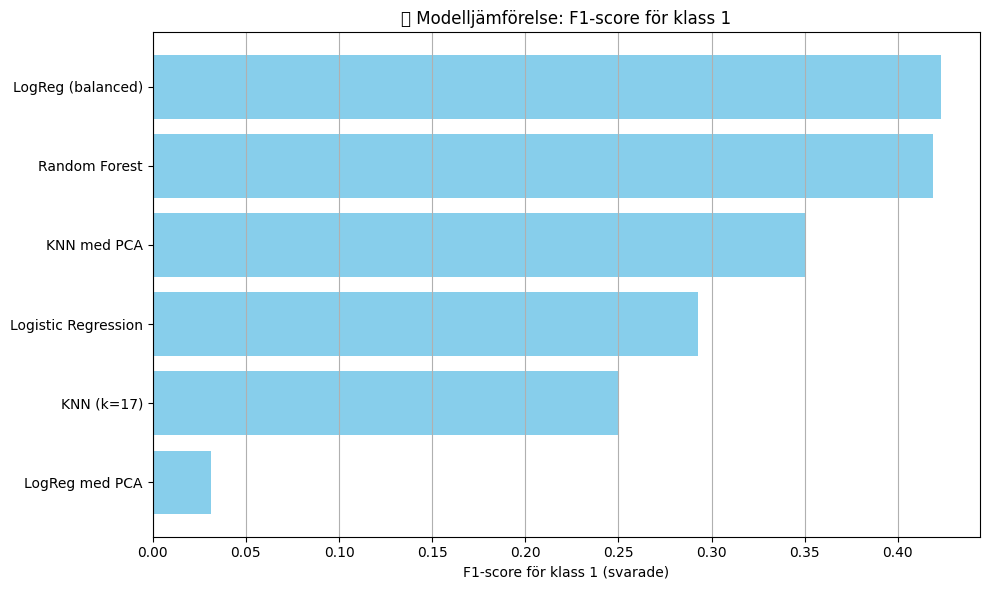

In [ ]:
plt.figure(figsize=(10, 6))
sorted_df = results_df.sort_values(by="F1_1", ascending=False)
plt.barh(sorted_df["Modell"], sorted_df["F1_1"], color='skyblue')
plt.xlabel("F1-score för klass 1 (svarade)")
plt.title("📊 Modelljämförelse: F1-score för klass 1")
plt.gca().invert_yaxis()
plt.grid(axis='x')
plt.tight_layout()
plt.show()


slutsats : Använd LogReg (balanced) eller Random Forest